In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('plot.mplstyle')
import numpy as np
from scipy import stats
from scipy import interpolate
from sscpol.jet_fns import *
from sscpol.fitter import SSC_Fitter

# Run

In [ ]:
#Run single
x0 = [6.44651e+37, 1.58650e+10, 1.97865e+00, 3.27639e+01, 1.73750e+01, 7.34230e-05, 1.58989e+00, 1.20151e+00, 5.11E5]
S, IC = run_ssc(x0, nblocks=1, seed=40)

In [5]:
#Run multiple
N = 10
S_final = np.zeros((4,50))
IC_final = np.zeros((4,50))
for seed in np.random.randint(10000, size=N):
    ## [W_j [W], E_max [eV], alpha, theta_open_p [deg], gamma_bulk, B0 [T], theta_obs [deg], A_eq, E_min [eV]]
    params = [6.44651e+37, 1.58650e+10, 1.97865e+00, 3.27639e+01, 1.73750e+01, 
          7.34230e-05, 1.58989e+00, 1.20151e+00, 5.11E5]
    S, IC = run_ssc(params, nblocks=1, seed=seed)
    S_final += S
    IC_final += IC
    
#Averaging stokes parameters over all of the N runs
S = S_final / N
IC = IC_final / N
#Can and should also calculate standard deviation for the plots below 

# Plot

In [6]:
#Form combined stokes parameters (IC + S)
f = np.logspace(-3,9, 500)
Tot = np.stack([f, np.interp(f, S[0], S[1]) + np.interp(f, IC[0], IC[1]),
                np.interp(f, S[0], S[2]) + np.interp(f, IC[0], IC[2]),
                np.interp(f, S[0], S[3]) + np.interp(f, IC[0], IC[3]),])

/tmp/ipykernel_662/2916697590.py:3: RuntimeWarning: invalid value encountered in true_divide
  IC_Pi = np.sqrt(IC[2]**2 + IC[3]**2) / IC[1]


Text(0.5, 0, '$h\\nu$ [eV]')

2022-04-11 17:30:53,989 - matplotlib.font_manager - WARNING - findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
2022-04-11 17:30:53,990 - matplotlib.font_manager - WARNING - findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive


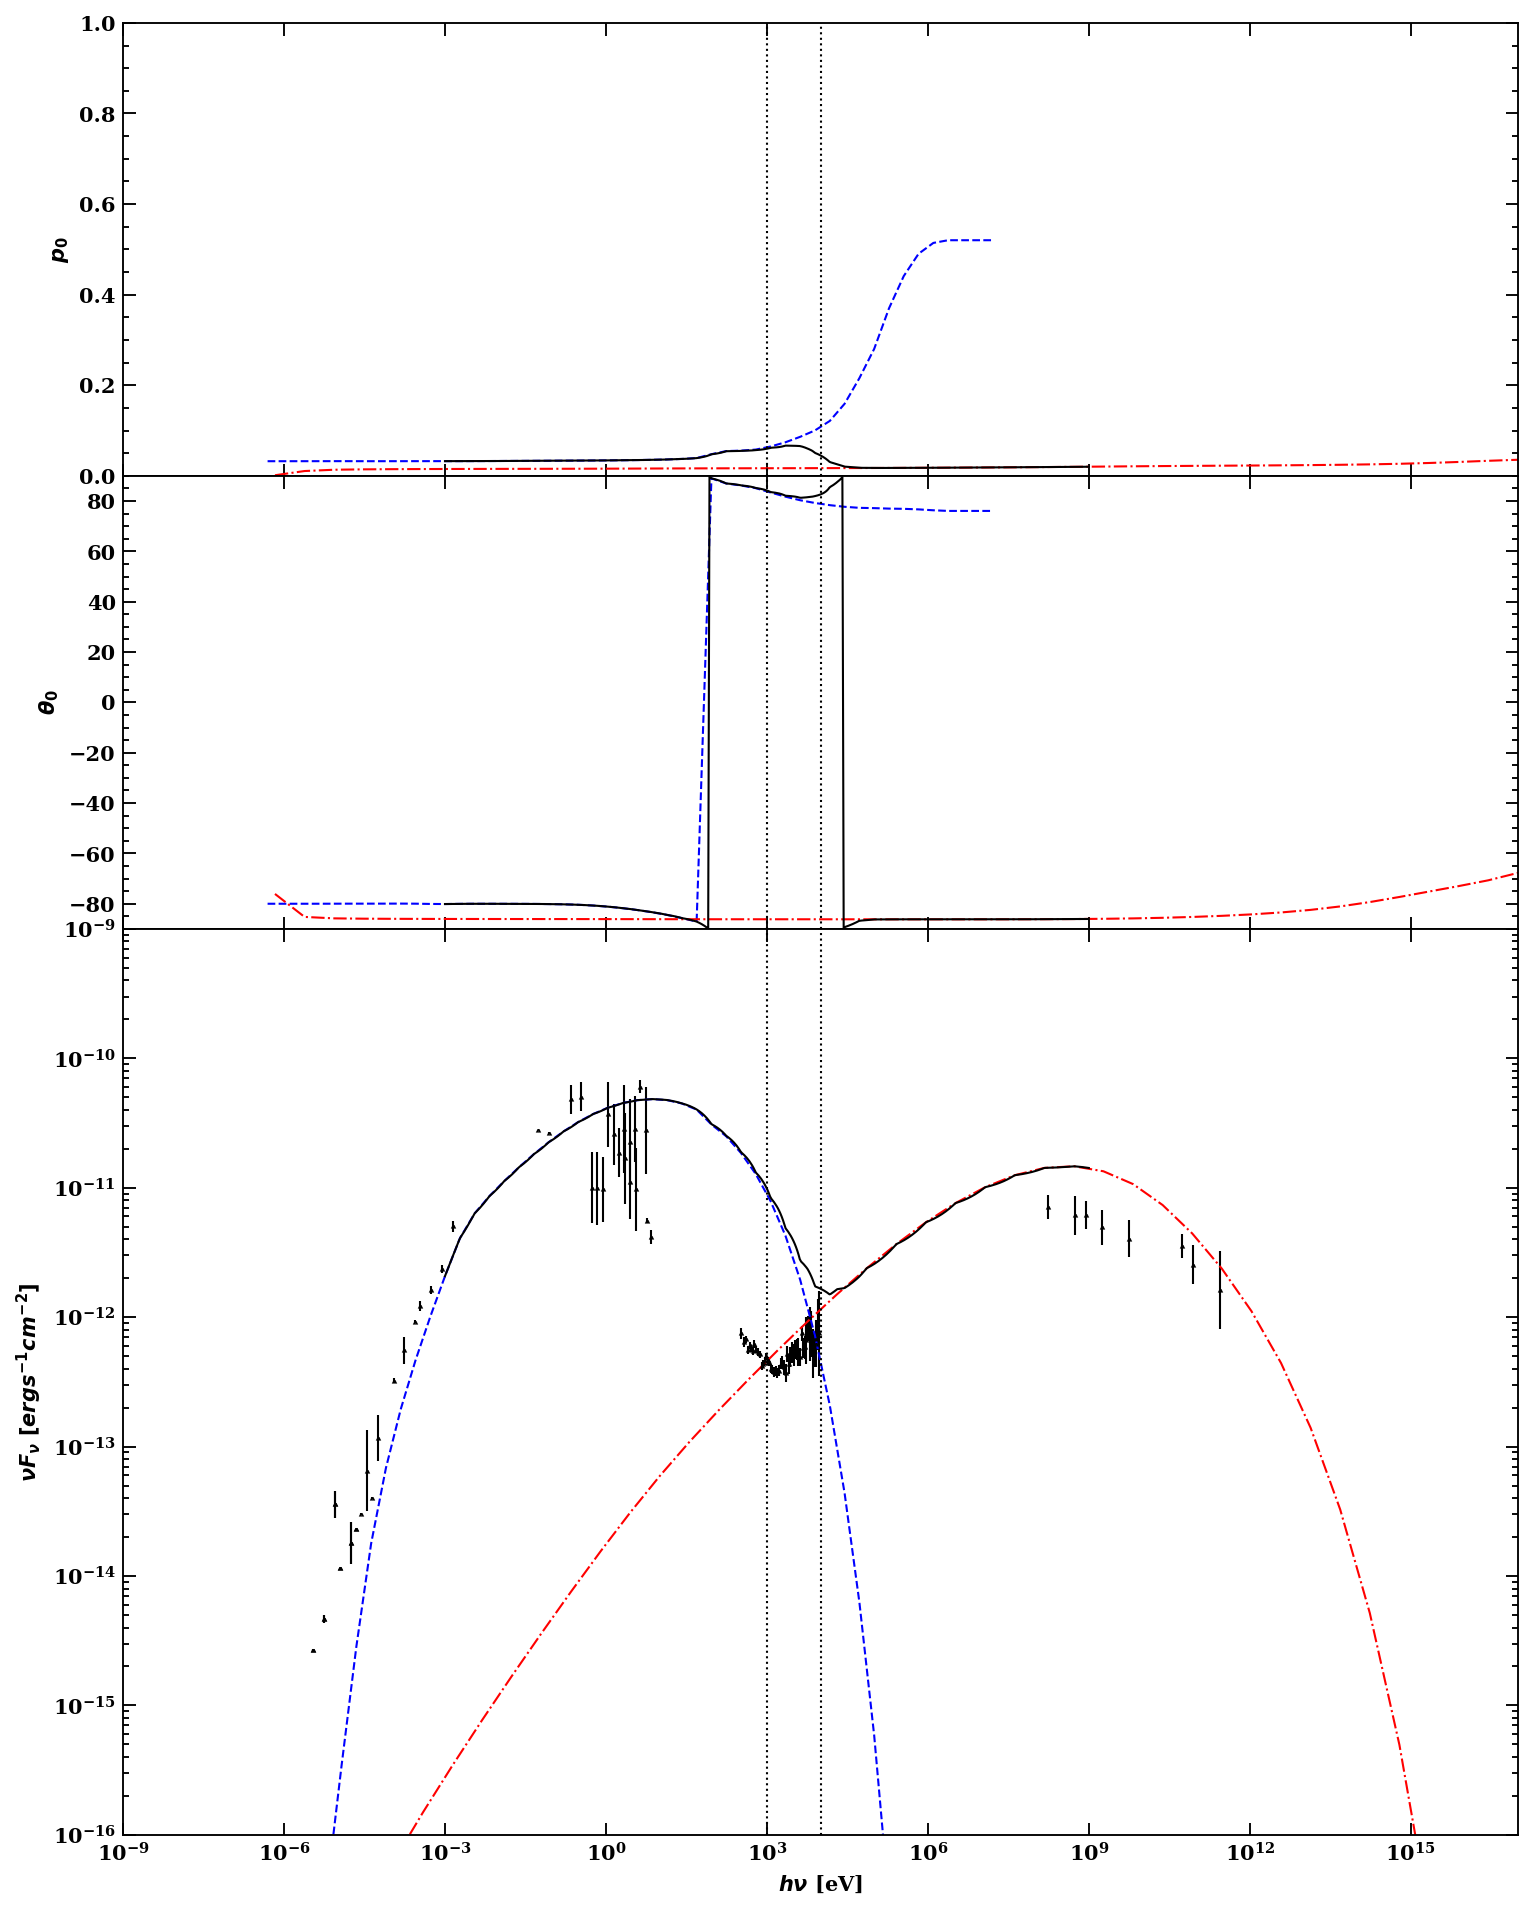

In [7]:
#Calculate PA and Pi from Stokes parameters.
S_Pi = np.sqrt(S[2]**2 + S[3]**2) / S[1]
IC_Pi = np.sqrt(IC[2]**2 + IC[3]**2) / IC[1]
Tot_Pi = np.sqrt(Tot[2]**2 + Tot[3]**2) / Tot[1]

S_PA = 0.5*np.arctan2(S[3],S[2])
IC_PA = 0.5*np.arctan2(IC[3],IC[2])
Tot_PA = 0.5*np.arctan2(Tot[3],Tot[2])

#Need distance conversion to get blazar flux right, must change depending on blazar being fit.
# J0211 ------ d_Blazar = 1000E6*3.08E18 
                #z = 0.2
# S5 ------ d_Blazar = 1627E6*3.08E18 
                #z = 0.31
# TXS ------ d_Blazar = 1789E6*3.08E18 
                #z = 0.3365

d_Blazar = 1627E6*3.08E18 
z = 0.31
dist_factor = 1.0E7*(1.0/((4.0*np.pi*d_Blazar**2.0)*(1.0+z)**2.0))

#Convert emitted flux by distance factor
S_P = S[1] * dist_factor
IC_P = IC[1] * dist_factor
Tot_P = Tot[1] * dist_factor

#Plot everything
fig, (ax1,ax2,ax3) = plt.subplots(figsize=(12,16), nrows=3, gridspec_kw={'hspace': 0, 'height_ratios': (0.25,0.25,0.5)})

ax1.plot(S[0], S_Pi, color='b', ls='--')
ax1.plot(IC[0], IC_Pi, color='r', ls='-.')
ax1.plot(Tot[0], Tot_Pi, color='k', ls='-')

ax2.plot(S[0], S_PA*180/np.pi, color='b', ls='--')
ax2.plot(IC[0], IC_PA*180/np.pi, color='r', ls='-.')
ax2.plot(Tot[0], Tot_PA*180/np.pi, color='k', ls='-')

ax3.plot(S[0], S_P, color='b', ls='--')
ax3.plot(IC[0], IC_P, color='r', ls='-.')
ax3.plot(Tot[0], Tot_P, color='k', ls='-')

#load and plot data points for blazar
data_plot = np.loadtxt('data/new_data_sed_CGRaBSJ0211+1051_XMM.txt')
data_plot2 = np.loadtxt('data/new_data_sed_CGRaBSJ0211+1051.txt')
J0211_pts = np.concatenate([data_plot,data_plot2], axis=0)
ax3.errorbar(10**J0211_pts[:,0], 10**J0211_pts[:,2],
             yerr=np.stack([np.abs(10**J0211_pts[:,2] - 10**(J0211_pts[:,2] - J0211_pts[:,3])),np.abs(10**J0211_pts[:,2] - 10**(J0211_pts[:,2] + J0211_pts[:,3]))]),
             color='k', markersize=1, ls="", marker='^')


for ax in [ax1,ax2,ax3]:
    ax.set_xscale('log')
    ax.set_xlim(1e-9, 1e17)
    ax.axvline(1e3,color='k',ls=":")
    ax.axvline(1e4,color='k',ls=":")
    
    
ax1.set_ylim(0, 1)
ax2.set_ylim(-90, 90)
ax3.set_yscale('log')
ax3.set_ylim(1e-16, 1e-9)

ax1.tick_params(labelbottom=False)
ax2.tick_params(labelbottom=False)

ax1.set_ylabel(r"$p_0$")
ax2.set_ylabel(r"$\theta_0$")
ax3.set_ylabel(r"$\nu F_{\nu}$ $[ergs^{-1}cm^{-2}]$")
ax3.set_xlabel(r"$h\nu$ [eV]")